# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [4]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.99812212819963
Mean of train-time output:  10.009874517210564
Mean of test-time output:  9.99812212819963
Fraction of train-time output set to zero:  0.699664
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.99812212819963
Mean of train-time output:  9.992874352483557
Mean of test-time output:  9.99812212819963
Fraction of train-time output set to zero:  0.400224
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.99812212819963
Mean of train-time output:  9.992721331061508
Mean of test-time output:  9.99812212819963
Fraction of train-time output set to zero:  0.250392
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [5]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445611179049964e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [6]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0.5, 0.75, 1.0]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              weight_scale=5e-2, dtype=np.float64,
                              dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    print('\n')

Running check with dropout =  0.5
Initial loss:  2.309771209610118
W1 relative error: 2.694274363733021e-07
W2 relative error: 7.439246147919978e-08
W3 relative error: 1.910371122296728e-08
b1 relative error: 4.112891126518e-09
b2 relative error: 5.756217724722137e-10
b3 relative error: 1.3204470857080166e-10


Running check with dropout =  0.75
Initial loss:  2.306133548427975
W1 relative error: 8.72986097970181e-08
W2 relative error: 2.9777307885797295e-07
W3 relative error: 1.8832780806174298e-08
b1 relative error: 5.379486003985169e-08
b2 relative error: 3.6529949080385546e-09
b3 relative error: 9.987242764516995e-11


Running check with dropout =  1.0
Initial loss:  2.3053332250963194
W1 relative error: 1.2744095365229032e-06
W2 relative error: 4.678743300473988e-07
W3 relative error: 4.331673892536035e-08
b1 relative error: 4.0853539035931665e-08
b2 relative error: 1.951342257912746e-09
b3 relative error: 9.387142701440351e-11




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [7]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0.6, 1.0]
for dropout in dropout_choices:
    model = FullyConnectedNet([100, 100, 100], dropout=dropout)

    solver = Solver(model, small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 5e-4,
                    },
                    verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.301218
(Epoch 0 / 25) train acc: 0.132000; val_acc: 0.117000
(Epoch 1 / 25) train acc: 0.134000; val_acc: 0.121000
(Epoch 2 / 25) train acc: 0.160000; val_acc: 0.147000
(Epoch 3 / 25) train acc: 0.250000; val_acc: 0.184000
(Epoch 4 / 25) train acc: 0.314000; val_acc: 0.258000
(Epoch 5 / 25) train acc: 0.308000; val_acc: 0.272000
(Epoch 6 / 25) train acc: 0.324000; val_acc: 0.286000
(Epoch 7 / 25) train acc: 0.360000; val_acc: 0.288000
(Epoch 8 / 25) train acc: 0.358000; val_acc: 0.277000
(Epoch 9 / 25) train acc: 0.362000; val_acc: 0.263000
(Epoch 10 / 25) train acc: 0.390000; val_acc: 0.309000
(Epoch 11 / 25) train acc: 0.418000; val_acc: 0.302000
(Epoch 12 / 25) train acc: 0.418000; val_acc: 0.255000
(Epoch 13 / 25) train acc: 0.460000; val_acc: 0.303000
(Epoch 14 / 25) train acc: 0.466000; val_acc: 0.313000
(Epoch 15 / 25) train acc: 0.448000; val_acc: 0.303000
(Epoch 16 / 25) train acc: 0.476000; val_acc: 0.308000
(Epoch 17 / 25) train acc: 0.468000; val

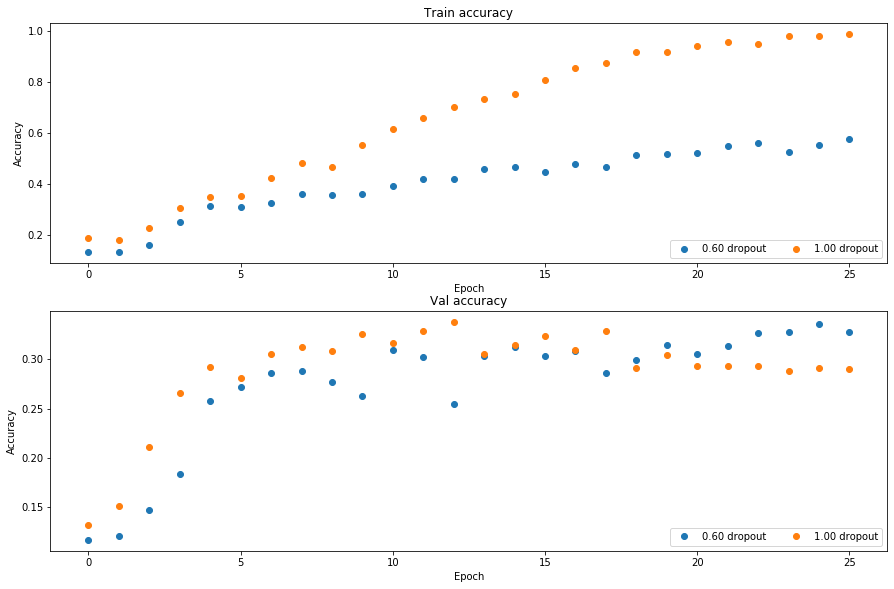

In [8]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:

Yes it does regularization. Because of the fact that the model with and without dropout have very similar validation accuracies as it can be seen from the bottom figure. However, the model without dropout (blue) has significantly higher training accury compared to the model with dropout (orange) as it can be seen from the top figure. This means that the additional training accuracy the model without dropout has is overfitting and the model with dropout, in fact, regularize it. As mentioned in the class we can also think of the dropout in fact regularizing each hidden unit to work well in many different contexts.

##### Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 23%, 1) 
where if you get 55% or higher validation accuracy, you get full points.

In [9]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #
optimizer = 'adam'


layer_dims = [400, 400, 400]
weight_scale = 0.04
learning_rate = 3e-3
lr_decay = 0.95
dropout = 0.8

solvers = {}
model = FullyConnectedNet(layer_dims, weight_scale = weight_scale, dropout = dropout,
                          use_batchnorm=True)

solver = Solver(model, data,
                num_epochs = 20, batch_size = 500,
                update_rule = optimizer,
                optim_config = {
                  'learning_rate': learning_rate,
                },
                lr_decay = lr_decay,
                verbose=True, print_every = 50)
solver.train()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


(Iteration 1 / 1960) loss: 2.468245
(Epoch 0 / 20) train acc: 0.190000; val_acc: 0.195000
(Iteration 51 / 1960) loss: 1.617484
(Epoch 1 / 20) train acc: 0.505000; val_acc: 0.481000
(Iteration 101 / 1960) loss: 1.544442
(Iteration 151 / 1960) loss: 1.414702
(Epoch 2 / 20) train acc: 0.537000; val_acc: 0.503000
(Iteration 201 / 1960) loss: 1.338823
(Iteration 251 / 1960) loss: 1.260380
(Epoch 3 / 20) train acc: 0.550000; val_acc: 0.534000
(Iteration 301 / 1960) loss: 1.394521
(Iteration 351 / 1960) loss: 1.220595
(Epoch 4 / 20) train acc: 0.582000; val_acc: 0.539000
(Iteration 401 / 1960) loss: 1.171243
(Iteration 451 / 1960) loss: 1.346148
(Epoch 5 / 20) train acc: 0.626000; val_acc: 0.560000
(Iteration 501 / 1960) loss: 1.153530
(Iteration 551 / 1960) loss: 1.235425
(Epoch 6 / 20) train acc: 0.622000; val_acc: 0.572000
(Iteration 601 / 1960) loss: 1.159588
(Iteration 651 / 1960) loss: 1.122976
(Epoch 7 / 20) train acc: 0.643000; val_acc: 0.572000
(Iteration 701 / 1960) loss: 1.129781
(

# layers.py

In [ ]:
import numpy as np
import pdb

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the output of the forward pass.  Notice the dimensions
    #   of w are D x M, which is the transpose of what we did in earlier 
    #   assignments.
    # ================================================================ #
    
    x_transformed = x.reshape(x.shape[0], -1) 
    out = np.dot(x_transformed,w) + b

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
      
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
      - w: A numpy array of weights, of shape (D, M)
      - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the gradients for the backward pass.
    # Notice:  
    #   dout is N x M
    #   dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
    #   dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
    #   db should be M; it is just the sum over dout examples
    # ================================================================ #
    x_transformed = x.reshape(x.shape[0], -1)   
    dx = np.dot(dout,w.T)
    dx = dx.reshape(x.shape)
    dw = np.dot(x_transformed.T,dout)
    db = np.sum(dout,axis=0)

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU forward pass.
    # ================================================================ #
    f = lambda x: x * (x > 0)   # ReLU
    out = f(x)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU backward pass
    # ================================================================ #
    # ReLU directs linearly to those > 0
    x_transformed = x.reshape(x.shape[0], -1) 
    ones = np.ones(dout.shape)
    dx = dout * (x_transformed >= 0)
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   A few steps here:
        #     (1) Calculate the running mean and variance of the minibatch.
        #     (2) Normalize the activations with the running mean and variance.
        #     (3) Scale and shift the normalized activations.  Store this
        #         as the variable 'out'
        #     (4) Store any variables you may need for the backward pass in
        #         the 'cache' variable.
        # ================================================================ #

        Mean_minibatch = x.mean(axis=0) 
        Variance_minibatch = np.var(x,axis=0)

        running_mean = momentum * running_mean  +  (1.0 - momentum) * Mean_minibatch 
        running_var = momentum * running_var  +  (1.0 - momentum) * Variance_minibatch

        Mean_minibatch = np.expand_dims(Mean_minibatch, axis=0)                             # 1 * D
        Variance_minibatch = np.expand_dims(Variance_minibatch, axis=0)                             # 1 * D

        x_normal = (x - Mean_minibatch)/( np.sqrt(Variance_minibatch + eps )  )                # normalizing x

        out = np.expand_dims(gamma, axis=0) * x_normal + np.expand_dims(beta, axis=0)

        cache = (Mean_minibatch, Variance_minibatch, x_normal, gamma, beta, x, eps)

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the testing time normalized activation.  Normalize using
        #   the running mean and variance, and then scale and shift appropriately.
        #   Store the output as 'out'.
        # ================================================================ #
        
        x_norm = (x - running_mean)/(np.sqrt(running_var.T))                                     # normalizing x 
        out = np.expand_dims(gamma, axis=0) * x_norm + np.expand_dims(beta, axis=0)

        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.
    
    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.
    
    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
    # ================================================================ #
    Mean_minibatch = cache[0]               # D
    Variance_minibatch = cache[1]           # D
    x_normal = cache[2]                     # N * D
    gamma = cache[3]                        # D
    beta = cache[4]                         # D
    x = cache[5]                            # N * D
    eps = cache[6]                          # scalar

    M = x_normal.shape[0]
    std = np.sqrt(Variance_minibatch + eps)             # D

    dbeta = dout.sum(axis=0)                            # D
    dgamma = np.sum(x_normal * dout ,axis = 0)           # D
    dx_hat = gamma * dout                               # D -- N * D
    da = (1.0 / std) * dx_hat                           # D -- N * D                                                     
    dMu = np.sum(-da , axis = 0)                        # D 
    dVar = np.sum((-1.0 / (2*np.power(std,3))) * dx_hat * (x - Mean_minibatch) , axis = 0)         # D
    dx = (1.0 / std) * dx_hat + (1.0 / M) * dMu + (2.0 / M ) * dVar * (x - Mean_minibatch)          # N * D
   
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during training time.  
        #   Store the masked and scaled activations in out, and store the 
        #   dropout mask as the variable mask.
        # ================================================================ #
        
        
        mask = (np.random.rand(*x.shape) < p) / p
        out =  mask * x  
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    
    elif mode == 'test':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during test time.
        # ================================================================ #
        
        
        out = x
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']
    
    dx = None
    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during training time.
        # ================================================================ #
        
        
        dx = mask * dout
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during test time.
        # ================================================================ #
        
        
        dx = dout
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    return dx

def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx



# fc_net

In [ ]:
import numpy as np
import pdb

from .layers import *
from .layer_utils import *

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.
    
    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
    
    def __init__(self, input_dim=3*32*32, hidden_dims=100, num_classes=10,
                 dropout=0, weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dims: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Initialize W1, W2, b1, and b2.  Store these as self.params['W1'], 
        #   self.params['W2'], self.params['b1'] and self.params['b2']. The
        #   biases are initialized to zero and the weights are initialized
        #   so that each parameter has mean 0 and standard deviation weight_scale.
        #   The dimensions of W1 should be (input_dim, hidden_dim) and the
        #   dimensions of W2 should be (hidden_dims, num_classes)
        # ================================================================ #
        size_W1 = (input_dim, hidden_dims)
        size_W2 = (hidden_dims,num_classes)
    
        self.params['W1'] = np.random.normal(loc=0.0,scale=weight_scale,size = size_W1)
        self.params['b1'] = np.zeros(hidden_dims)
        self.params['W2'] = np.random.normal(loc=0.0,scale=weight_scale,size = size_W2)
        self.params['b2'] = np.zeros(num_classes)

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """  
        scores = None

        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the forward pass of the two-layer neural network. Store
        #   the class scores as the variable 'scores'.  Be sure to use the layers
        #   you prior implemented.
        # ================================================================ #    
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']

        H, cache_h = affine_relu_forward(X, W1, b1)
        Z, cache_z = affine_forward(H, W2, b2)

        scores = Z
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores
        
        loss, grads = 0, {}
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the backward pass of the two-layer neural net.  Store
        #   the loss as the variable 'loss' and store the gradients in the 
        #   'grads' dictionary.  For the grads dictionary, grads['W1'] holds
        #   the gradient for W1, grads['b1'] holds the gradient for b1, etc.
        #   i.e., grads[k] holds the gradient for self.params[k].
        #
        #   Add L2 regularization, where there is an added cost 0.5*self.reg*W^2
        #   for each W.  Be sure to include the 0.5 multiplying factor to 
        #   match our implementation.
        #
        #   And be sure to use the layers you prior implemented.
        # ================================================================ #    
        loss, dz = softmax_loss(scores, y)
        loss += 0.5*self.reg*(np.sum(W1*W1) + np.sum(W2*W2))

        dh, dw2, db2 = affine_backward(dz, cache_z)
        dx, dw1, db1 = affine_relu_backward(dh, cache_h)

        grads['W1'] = dw1 + self.reg * W1
        grads['b1'] = db1
        grads['W2'] = dw2 + self.reg * W2
        grads['b2'] = db2

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        return loss, grads


class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch normalization as options. For a network with L layers,
    the architecture will be
    
    {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
    
    where batch normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.
    
    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=1, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.
        
        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - use_batchnorm: Whether or not the network should use batch normalization.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        if dropout <= 0 or dropout > 1: print ("Wrong dropout probability")
        self.use_batchnorm = use_batchnorm
        self.use_dropout = dropout < 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        # ================================================================ #
        # YOUR CODE HERE:
        #   Initialize all parameters of the network in the self.params dictionary.
        #   The weights and biases of layer 1 are W1 and b1; and in general the 
        #   weights and biases of layer i are Wi and bi. The
        #   biases are initialized to zero and the weights are initialized
        #   so that each parameter has mean 0 and standard deviation weight_scale.
        #
        #   BATCHNORM: Initialize the gammas of each layer to 1 and the beta
        #   parameters to zero.  The gamma and beta parameters for layer 1 should
        #   be self.params['gamma1'] and self.params['beta1'].  For layer 2, they
        #   should be gamma2 and beta2, etc. Only use batchnorm if self.use_batchnorm 
        #   is true and DO NOT do batch normalize the output scores.
        # ================================================================ #
        for i in np.arange(1,self.num_layers+1):           #iterating through layers: h1, h2, .., h_end, scores
            
            

            name_W = 'W' + str(i)
            name_b = 'b' + str(i)
            name_gamma = 'gamma' + str(i)
            name_beta = 'beta' + str(i)



            if i == 1:                   # first layer
                self.params[name_W] = np.random.normal(loc=0.0,scale=weight_scale,size = (input_dim,hidden_dims[i-1]))
                self.params[name_b] = np.zeros(hidden_dims[i-1]) 
                if self.use_batchnorm:
                    self.params[name_gamma] = np.ones(hidden_dims[i-1])
                    self.params[name_beta]  = np.zeros(hidden_dims[i-1]) 
            elif i == self.num_layers:         # last layer
                self.params[name_W] = np.random.normal(loc=0.0,scale=weight_scale,size = (hidden_dims[i-2],num_classes))
                self.params[name_b] = np.zeros(num_classes) 
            else:                        # intermediate layers
                self.params[name_W] = np.random.normal(loc=0.0,scale=weight_scale,size = (hidden_dims[i-2],hidden_dims[i-1]))
                self.params[name_b] = np.zeros(hidden_dims[i-1])
                if self.use_batchnorm:
                    self.params[name_gamma] = np.ones(hidden_dims[i-1])
                    self.params[name_beta]  = np.zeros(hidden_dims[i-1]) 


        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
        if seed is not None:
            self.dropout_param['seed'] = seed
    
        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.use_batchnorm:
            self.bn_params = [{'mode': 'train'} for i in np.arange(self.num_layers - 1)]
        
        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.dropout_param is not None:
            self.dropout_param['mode'] = mode   
        if self.use_batchnorm:
            for bn_param in self.bn_params:
                bn_param['mode'] = mode

        scores = None
    
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the forward pass of the FC net and store the output
        #   scores as the variable "scores".
        #
        #   BATCHNORM: If self.use_batchnorm is true, insert a bathnorm layer
        #   between the affine_forward and relu_forward layers.  You may
        #   also write an affine_batchnorm_relu() function in layer_utils.py.
        #
        #   DROPOUT: If dropout is non-zero, insert a dropout layer after
        #   every ReLU layer.
        # ================================================================ #
        H = []
        cache_h = []
        cache_dropout = []
        
        for i in np.arange(1,self.num_layers + 1):
            name_W = 'W' + str(i)
            name_b = 'b' + str(i)
            name_gamma = 'gamma' + str(i)
            name_beta = 'beta' + str(i)
            
            if i == 1:                             # first layer
                if self.use_batchnorm == False:
                    H.append(affine_relu_forward(X, self.params[name_W], self.params[name_b])[0])
                    cache_h.append(affine_relu_forward(X, self.params[name_W], self.params[name_b])[1])
                else:
                    H.append(affine_batchnorm_relu_forward(X, self.params[name_W], self.params[name_b], self.params[name_gamma],                                    self.params[name_beta], self.bn_params[i-1])[0])
                    cache_h.append(affine_batchnorm_relu_forward(X, self.params[name_W], self.params[name_b], self.params[name_gamma],                               self.params[name_beta], self.bn_params[i-1])[1])
                  
                if self.use_dropout > 0:
                    H[0] = dropout_forward(H[0], self.dropout_param)[0]
                    cache_dropout.append(dropout_forward(H[0], self.dropout_param)[1])    
                    
            elif i == self.num_layers:               # last layer    
                scores = affine_forward(H[i-2], self.params[name_W], self.params[name_b])[0]
                cache_h.append(affine_forward(H[i-2], self.params[name_W], self.params[name_b])[1])
            
            else:                                     # intermediate layers
                if self.use_batchnorm == False:
                    H.append(affine_relu_forward(H[i-2], self.params[name_W], self.params[name_b])[0])
                    cache_h.append(affine_relu_forward(H[i-2], self.params[name_W], self.params[name_b])[1])
                else: 
                    H.append(affine_batchnorm_relu_forward(H[i-2], self.params[name_W], self.params[name_b], self.params[name_gamma],                                self.params[name_beta], self.bn_params[i-1])[0])
                    cache_h.append(affine_batchnorm_relu_forward(H[i-2], self.params[name_W], self.params[name_b], self.params[name_gamma],                          self.params[name_beta], self.bn_params[i-1])[1])
                    
                if self.use_dropout > 0:
                    H[i-1] = dropout_forward(H[i-1], self.dropout_param)[0]
                    cache_dropout.append(dropout_forward(H[i-1], self.dropout_param)[1])        



        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the backwards pass of the FC net and store the gradients
        #   in the grads dict, so that grads[k] is the gradient of self.params[k]
        #   Be sure your L2 regularization includes a 0.5 factor.
        #
        #   BATCHNORM: Incorporate the backward pass of the batchnorm.
        #
        #   DROPOUT: Incorporate the backward pass of dropout.
        # ================================================================ #
        loss, dz = softmax_loss(scores, y)

        dh = []
        for i in np.arange(self.num_layers,0,-1):
            name_W = 'W' + str(i)
            name_b = 'b' + str(i)
            name_gamma = 'gamma' + str(i)
            name_beta = 'beta' + str(i)

            loss += (0.5 * self.reg * np.sum(self.params[name_W]*self.params[name_W]))

            if i == self.num_layers:
                dh1, grads[name_W], grads[name_b] = affine_backward(dz, cache_h[self.num_layers-1])
                dh.append(dh1)
            else:
                if self.use_batchnorm == False:
                    
                    if self.use_dropout > 0:
                        dh[self.num_layers-i-1] = dropout_backward(dh[self.num_layers-i-1], cache_dropout[i-1])
                    
                    dr1, grads[name_W], grads[name_b] = affine_relu_backward(dh[self.num_layers-i-1], cache_h[i-1])
                    dh.append(dr1)
                else: 
                    
                    if self.use_dropout > 0:
                        dh[self.num_layers-i-1] = dropout_backward(dh[self.num_layers-i-1], cache_dropout[i-1])
                    
                    dr2, grads[name_W], grads[name_b], grads[name_gamma], grads[name_beta] =                                                                                              affine_batchnorm_relu_backward(dh[self.num_layers-i-1], cache_h[i-1])
                    dh.append(dr2)

            grads[name_W] += self.reg * self.params[name_W]
       
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        return loss, grads

